In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

In [2]:
#Tierra estática y Luna con w constante. 

omega= 2.6617e-6


In [3]:
#CONSTANTES

d= 3.844e8
G= 6.67e-11
m_t= 5.9736e24
r_t= 6.3781e6
m_l= 0.07349e24
r_l= 1.7374e6

triangle= G*m_t/(d**3)
mu= m_l/m_t

In [4]:
theta = 25./180.*np.pi #Perigeo orbital
v0= 11100. #Velocidad escape de la tierra

r0= r_t/d
phi0= 0.
pr0= (v0/d)*np.cos(theta-phi0)
pf0= r0*(v0/d)*np.sin(theta-phi0)

ci=[r0, phi0, pr0, pf0]

#Funciones auxiliares 

def r2 (r, phi, theta,t): 
    return np.sqrt(1+r**2-2*r*np.cos(phi-omega*t))
#Sistema de 4 ecuaciones 

def ec1(r,phi,pr,pf,t):
    return pr 

def ec2(r,phi,pr,pf,t):
    return pf/((r**2)+1e-9)

def ec3(r,phi,pr,pf,t):
    return ((pf**2/r**3)-triangle*((1/r**2)+((mu/((r2(r,phi,theta,t)+1e-9)**3))*(r-np.cos(phi-omega*t)))))

def ec4(r,phi,pr,pf,t):
    return -((triangle*mu*r)/(((r2(r, phi, theta,t))+1e-9)**3))*np.sin(phi-omega*t)

In [5]:
def RK4_4(c_ini, t0, tf, h= 10):
    
    N= int((tf-t0)/h) + 1
    t= np.linspace(t0,tf,N)
    
    r = np.zeros([N])
    phi = np.zeros([N])
    pr = np.zeros([N])
    pf = np.zeros([N])
    
    r[0]=c_ini[0]
    phi[0]= c_ini[1]
    pr[0]=c_ini[2]
    pf[0]= c_ini[3]
    
    #Ahora ejecutaremos el método Runge Kutta 4 para un sistema de 4 ecuaciones. 
    #Debemos crear 4 K_i para cada función.
    
    K1= np.zeros(4)
    K2= np.zeros(4)
    K3= np.zeros(4)
    K4= np.zeros(4)
    
    
    for i in tqdm(range(1, N)):
        
        K1[0]= h*ec1(r[i-1], phi[i-1], pr[i-1], pf[i-1], t[i-1])
        K1[1]= h*ec2(r[i-1], phi[i-1], pr[i-1], pf[i-1], t[i-1])
        K1[2]= h*ec3(r[i-1], phi[i-1], pr[i-1], pf[i-1], t[i-1])
        K1[3]= h*ec4(r[i-1], phi[i-1], pr[i-1], pf[i-1], t[i-1])
        
        K2[0]= h*ec1(r[i-1]+0.5*K1[0], phi[i-1]+0.5*K1[1], pr[i-1]+0.5*K1[2], pf[i-1]+0.5*K1[3], t[i-1]+0.5*h)
        K2[1]= h*ec2(r[i-1]+0.5*K1[0], phi[i-1]+0.5*K1[1], pr[i-1]+0.5*K1[2], pf[i-1]+0.5*K1[3], t[i-1]+0.5*h)
        K2[2]= h*ec3(r[i-1]+0.5*K1[0], phi[i-1]+0.5*K1[1], pr[i-1]+0.5*K1[2], pf[i-1]+0.5*K1[3], t[i-1]+0.5*h)
        K2[3]= h*ec4(r[i-1]+0.5*K1[0], phi[i-1]+0.5*K1[1], pr[i-1]+0.5*K1[2], pf[i-1]+0.5*K1[3], t[i-1]+0.5*h)
        
        K3[0]= h*ec1(r[i-1]+0.5*K2[0], phi[i-1]+0.5*K2[1], pr[i-1]+0.5*K2[2], pf[i-1]+0.5*K2[3], t[i-1]+0.5*h)
        K3[1]= h*ec2(r[i-1]+0.5*K2[0], phi[i-1]+0.5*K2[1], pr[i-1]+0.5*K2[2], pf[i-1]+0.5*K2[3], t[i-1]+0.5*h)
        K3[2]= h*ec3(r[i-1]+0.5*K2[0], phi[i-1]+0.5*K2[1], pr[i-1]+0.5*K2[2], pf[i-1]+0.5*K2[3], t[i-1]+0.5*h)
        K3[3]= h*ec4(r[i-1]+0.5*K2[0], phi[i-1]+0.5*K2[1], pr[i-1]+0.5*K2[2], pf[i-1]+0.5*K2[3], t[i-1]+0.5*h)
        
        K4[0]= h*ec1(r[i-1]+K3[0], phi[i-1]+K3[1], pr[i-1]+K3[2], pf[i-1]+K3[3], t[i-1]+h)
        K4[1]= h*ec2(r[i-1]+K3[0], phi[i-1]+K3[1], pr[i-1]+K3[2], pf[i-1]+K3[3], t[i-1]+h)
        K4[2]= h*ec3(r[i-1]+K3[0], phi[i-1]+K3[1], pr[i-1]+K3[2], pf[i-1]+K3[3], t[i-1]+h)
        K4[3]= h*ec4(r[i-1]+K3[0], phi[i-1]+K3[1], pr[i-1]+K3[2], pf[i-1]+K3[3], t[i-1]+h)
        
        r[i]= r[i-1]+(K1[0]+2*K2[0]+2*K3[0]+K4[0])/6.
        phi[i]= phi[i-1]+(K1[1]+2*K2[1]+2*K3[1]+K4[1])/6.
        pr[i]= pr[i-1]+(K1[2]+2*K2[2]+2*K3[2]+K4[2])/6.
        pf[i]= pf[i-1]+(K1[3]+2*K2[3]+2*K3[3]+K4[3])/6.
    
    return t,r,phi

In [6]:
_t,_r,_phi= RK4_4(ci, 0, 7e5)

100%|██████████| 70000/70000 [00:15<00:00, 4429.95it/s]


In [7]:
tr=[]
rr=[]
phir=[]

for i in range(len(_t)):
    if i % 1000==0:
        tr.append(_t[i])
        rr.append(_r[i])
        phir.append(_phi[i])
t=np.array(tr)
r=np.array(rr)
phi=np.array(phir)

<IPython.core.display.Javascript object>


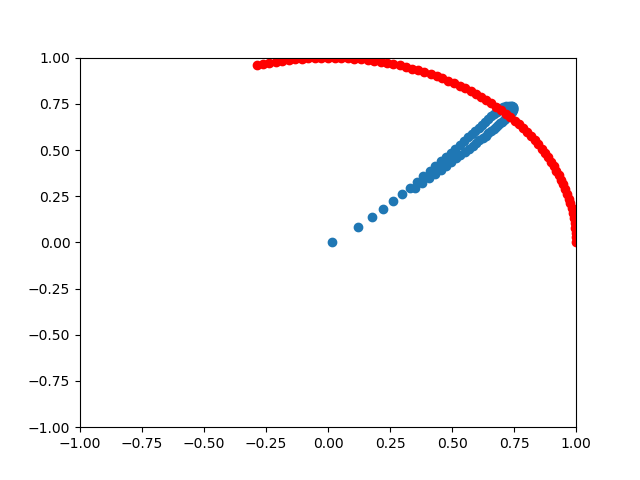

(-1, 1)

In [8]:
#Coordenadas cartesianas 
x= r*np.cos(phi)
y= r*np.sin(phi)
x_L= np.cos(omega*t)
y_L= np.sin(omega*t)
plt.scatter(x,y)
plt.scatter(x_L,y_L, c="r")
plt.xlim(-1,1)
plt.ylim(-1,1)

<IPython.core.display.Javascript object>


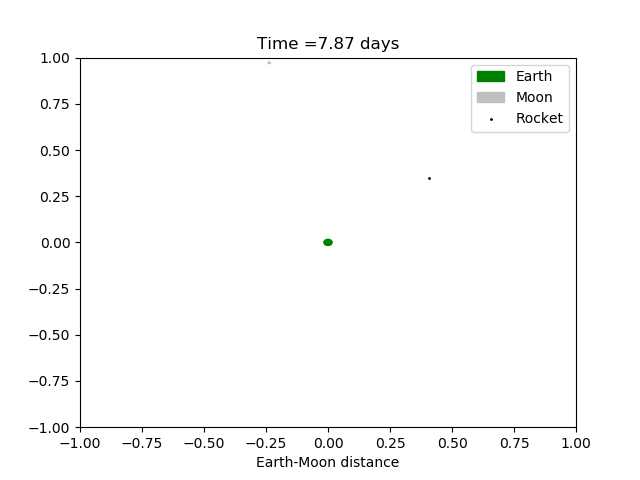

In [9]:
fig= plt.figure()
ax= fig.add_subplot(1,1,1)

def init():
    ax.set_xlim([-1.,1.])
    ax.set_ylim([-1.,1.])
    ax.set_xlabel("Earth-Moon distance")
def Update(i):
    plot= ax.clear()
    init()
    plot= ax.set_title("Time =%.2f days" %(t[i]/3600./24.))
    Tierra= plt.Circle((0,0), r_t/d, color="g", label= "Earth")
    Luna= plt.Circle((x_L[i], y_L[i]), r_l/d, color= "silver", label= "Moon")
    
    plot= ax.add_patch(Tierra)
    plot= ax.add_patch(Luna)
    
    plot= ax.scatter(x[i],y[i],s=1, c="k", label= "Rocket")
    plot=plt.legend()

    
    return plot
   
Animation= anim.FuncAnimation(fig,Update,frames=len(t), init_func=init)


In [10]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=10, metadata=dict(artist='Me'))
Animation.save('Rocket.mp4', writer=writer_)